

#   **Projeto de redes neurais:** 

<span style='color:Gray'>  Classificando se um asteroide é perigoso ou não. </span>

Autor: Wanderson Ferreira

**Descrição do dataset:**

> - **id:** ID exclusivo para cada asteroide;
>
> - **name:** nome do asteroide dado pela NASA;
>
> - **est_diameter_min:** diâmetro mínimo estimado em km;
>
> - **est_diameter_max:** diâmetro máximo estimado em km;
>
> - **relative_velocity:** velocidade relativa à Terra;
>
> - **miss_distance:** distância perdida em km;
>
> - **orbiting_body:** planeta que o asteroide orbita;
>
> - **sentry_object:** incluído no sentry - um sistema automatizado de monitoramento de colisões?;
>
> - **absolute_magnitude:** descreve a luminosidade intrínseca;
>
> - **hazardous:** feature booleana que mostra se o asteroide é prejudicial ou não;

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

#Dataset
url = 'https://raw.githubusercontent.com/wanderson42/Turing-Academy-Projects/main/datasets/neo.csv'
df = pd.read_csv(url)

#Primeiras impressões sobre o dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


O *dataset* é composto por 90836 instâncias (linhas) e 9 *features* e 1 *target* (colunas). Considerando que o *dataset* está limpíssimo, como parte da investigação inicial, segue abaixo uma breve análise a respeito dos dados, para ver quais informações são ou não pertinentes para construir as redes neurais.



**Engenharia de Atributos:**

In [ ]:
df.sample(n = 5).style.background_gradient(cmap = 'Set3')


,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
77164,54016310,(2020 FY2),0.024241,0.054205,44319.351849,1857380.555419,Earth,False,25.200000,False
43124,3797674,(2018 AB12),0.035039,0.078350,63047.152766,53628128.374357,Earth,False,24.400000,False
36380,3581555,(2011 TJ5),0.016016,0.035813,37672.023138,5994382.791275,Earth,False,26.100000,False
56201,2533541,533541 (2014 JU54),0.278327,0.622358,53725.093899,12937449.675424,Earth,False,19.900000,False
6997,3878589,(2019 TF3),0.006677,0.014929,39137.825300,54656278.302263,Earth,False,28.000000,False


In [ ]:
print(df['sentry_object'].value_counts(normalize=True))
print(df['orbiting_body'].value_counts(normalize=True))


False    1.0
Name: sentry_object, dtype: float64
Earth    1.0
Name: orbiting_body, dtype: float64




Como se pode ver, existem algumas *features* desnecessárias presentes no *dataset* que dificilmente contribuem para a construção do modelo preditivo. Listamos a seguir:

*   As *features* `id` e `name` são apenas rótulos de identificação dos 
asteróides. 

*   As *features* `orbiting_body` e `sentry_object` contém apenas um tipo de valor categórico, no caso "Earth" e "False", respectivamente.

Assim, podemos apagar todas essas *features* mencionadas acima.



In [ ]:
# Excluindo features com baixo poder preditivo.
df.drop(['id', 'name', 'orbiting_body','sentry_object'], inplace=True, axis=1)

Em relação aos valores 'False' e 'True' da *target* `hazardous`, estes necessitam ser codificados para 0 e 1, respectivamente.

In [ ]:
#Binarização
df['hazardous'] = df['hazardous'].map({False: 0, True: 1})

Vejamos agora o balanceamento da referida *target*.

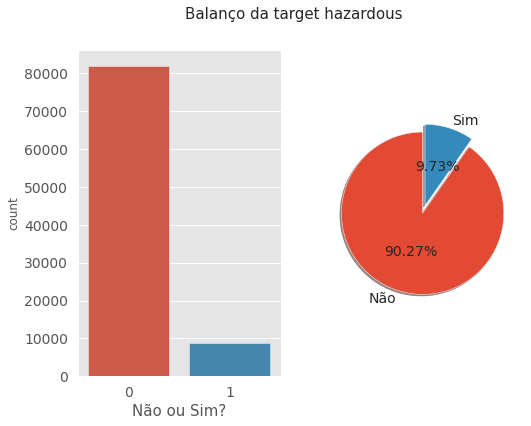

<Figure size 576x432 with 0 Axes>

In [ ]:
plt.rcParams['figure.figsize'] = (8, 6); plt.style.use('ggplot'); plt.subplot(1, 2, 1); sns.countplot(df['hazardous'])
plt.xlabel('Não ou Sim?', fontsize = 15); plt.yticks(fontsize=14); plt.xticks(fontsize=14); plt.subplot(1, 2, 2)
df['hazardous'].value_counts().plot(kind = 'pie', explode = [0, 0.1], autopct = '%.2f%%', startangle = 90,
                                       labels = ['Não','Sim'], shadow = True, pctdistance = 0.5,fontsize=14)
plt.axis('off'); plt.suptitle('Balanço da target hazardous', fontsize = 15); plt.figure(figsize=(8, 6)); plt.show()

Analisando os gráficos dispostos acima, claramente o dataset de treino possui uma _target_ consideravelmente desequilibrada, onde
90.27% das instâncias são rotuladas como 0 (asteróide não perigoso) e apenas 9.73% são rotulados como 1 (asteróide perigoso). A seguir construimos uma matriz de correlação entre features:

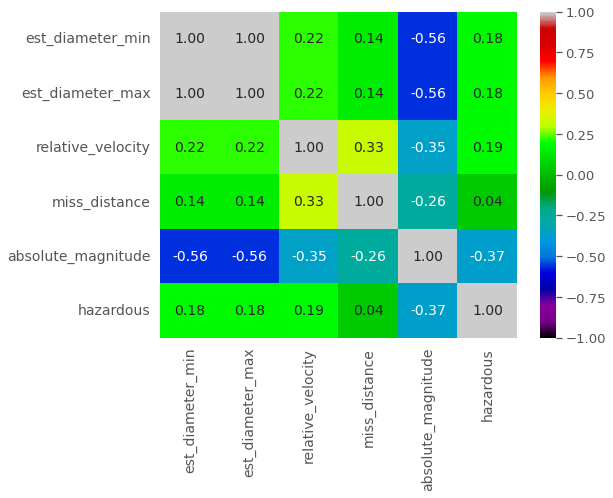

In [ ]:
plt.figure(figsize=(8, 6)); plt.xticks(fontsize=14); plt.yticks(fontsize=14); sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f',cmap="nipy_spectral",annot_kws={"fontsize":14}); sns.set(font_scale=1.2); plt.show()

A partir da matriz acima, conforme a escala do coeficiente de pearson, podemos observar resultados óbvios, como a correlação muito forte entre `est_diameter_min` e `est_diameter_max`. No entanto, a maioria das correlações entre a features são desprezíveis, cujos os valores estão situados entre 0 a ~0.3, ou seja, é bem pouco provável que tais features afetem umas as outras. Apenas algumas atribuições constituem valores fora desse intervalo, no caso as correlações de `est_diameter_min` e `est_diameter_max` com respeito a `absolute_magnitude`. Em relação a *target*, temos apenas uma correlação significativa, no caso, entre `hazardous` e `absolute_magnitude`.

 

**Redes Neural**

Agora que algumas técnicas de Engenharia de atributos foram aplicadas é hora de construir e treinar o modelo de rede neural. 


In [ ]:
import tensorflow as tf 
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix
class_names=np.array(['0','1'])
# Function to plot the confusion Matrix
def plot_confusion_matrix(cf_matrix):            
    group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(8,6)); ax = sns.heatmap(cf_matrix, annot=labels, fmt='',annot_kws={"fontsize":13},cmap="coolwarm")
    ax.set_title('Matriz de Confusão'); ax.set_xlabel('\nPredito', fontsize=14); ax.set_ylabel('Real', fontsize=14);
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Asteróide não perigoso','Asteróide perigoso'],fontsize=14)
    ax.yaxis.set_ticklabels(['Asteróide não perigoso','Asteróide perigoso'],fontsize=14)
    ## Display the visualization of the Confusion Matrix.
    plt.show()

Aqui efetuamos a divisão do *dataset* em uma proporção de 75:25 em dados de treinamento e teste, respectivamente. E também nesta etapa de preparação dos nossos dados, implementamos um recurso muito útil em problemas de classificação que é uma padronização nas features por meio do  método StandardScaler(). 

In [ ]:
y = df['hazardous']
X = df.drop(['hazardous'], axis = 1)

#Padronização de recursos
X = scaler.fit_transform(X)

#Dividindo o dataset numa base de treino e base de teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle = True, stratify=y,)

Agora que estamos com tudo que precisamos, a gente pode finalmente definir a arquitetura da nossa Rede Neural com o Keras. De forma totalmente arbitrária, definiu-se uma Rede Neural Profunda com 5 camadas Densas para calcular as funções de ativação em conjunto com os dados de entrada e pesos.


In [ ]:
#------------------------Arquitetura da Rede Neural--------------------------------
model = models.Sequential()  # Cria uma instância de Sequential
model.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1], ))) # A virgula é necessária quando se tem apenas 1 dimensão
model.add(layers.Dropout(0.4))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))
#----------------------------------------------------------------------------------

*   Na primeira camada com o parâmetro input_shape, por meio do número de colunas das features selecionadas no dataset (X_train_sm.shape[1]) defini um total de 5 neurônios.

*   As duas camadas intermediárias foram definidas arbitrariamente com 32 neurônios cada, onde cada uma foi ativada pela função relu (“Rectified Linear Unit”) que recebe os valores reais dos neurônios como input e os joga dentro do range 0 e 1.

*   Entre as camadas intermediárias foi adicionado duas camadas de Dropout que é uma técnica de regularização para produzir um modelo robusto que não overfita. Neste modelo defini que 40% dos valores de input serão dropados para regularização.

*   A última camada possui a quantidade de neurônios correspondente à quantidade de classes que o nosso problema de classificação possui, em se tratando de uma classificação binária “Verdadeiro/Falso”, é atribuido o valor 1 para a camada de saída, como esta reflete as probabilidades para cada uma das classes possíveis, a função sigmoid foi utilizada para ativação dessa camada.


Para treinar o modelo, foi utilizado o Adam, um algoritmo do *tipo stochastic gradient descent*, no qual define-se como os pesos da rede neural são atualizados (“optimizer”). Para calcular a diferença entre os dados de teste e de treino (“loss”), escolheu a função de custo *categorical crossentropy.*

Por fim, o método "fit" treina o modelo para um determinado número de "epochs" (iterações no *dataset*) com determinado "batch_size" (tamanho do lote que define o número de amostras que serão propagadas pela rede). 

In [ ]:
%%capture
# compile() configura o modelo, preparando ele para o treinamento
model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# fit() treina a rede neural
results = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Para vizualizarmos a performance do modelo segue o código abaixo. 

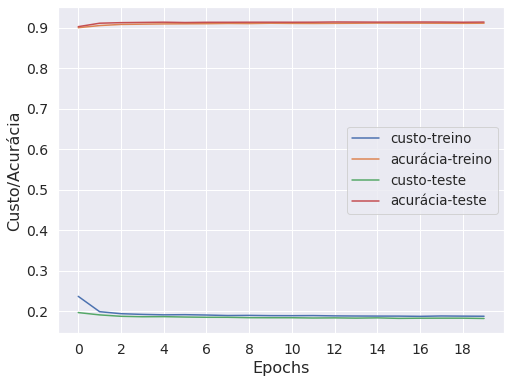

<Figure size 576x432 with 0 Axes>

In [ ]:
df_results = pd.DataFrame(results.history)
df_results.rename({'loss':'custo-treino','accuracy':'acurácia-treino',
                   'val_loss':'custo-teste','val_accuracy':'acurácia-teste'}, axis=1, inplace=True)
df_results.plot(); plt.legend(fontsize=13.5); plt.xlabel("Epochs", fontsize=16); plt.ylabel("Custo/Acurácia", fontsize=16); plt.xticks(np.arange(0,20, 2), fontsize=14); plt.yticks(fontsize=14);plt.figure(figsize=(8, 6)); plt.show()
#y_pred = model.predict(X_test); y_pred = [1.0 if p > 0.5 else 0 for p in y_pred]; print(classification_report(y_test, y_pred))

Como resultado, o gráfico acima mostra que ao final das 20 epochs, a rede neural conseguiu atingir uma acurácia superior a 90%, o que é um excelente resultado para este tipo de arquitetura. Observa-se como as curvas referentes aos datasets de treino e teste estão praticamente sobrepostas, tal comportamento é uma prova contundente que não houve problemas de overfitting durante a fase de treinamento.

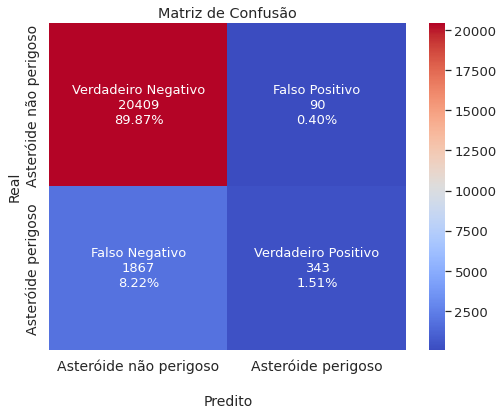

In [ ]:
#confusion matrix
cf_matrix = metrics.confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cf_matrix)

Agora inspecionando a perfomance do modelo no dateset de teste por meio da matriz de confusão (acima), observa-se que:

*   Cerca de 90% dos asteróides foram classificados pela rede neural como "verdadeiro negativo", isto é, não são potêncialmente perigosos. 

*   Somente 1.5% dos asteróides a rede neural previu como "verdadeiro positivo", ou seja, classificados como perigosos. 

*   Quanto ao erro de previsão do modelo, somente 8% dos asteróides são "falso negativo", em outras palavras, o modelo erroneamente previu que não eram potencialmente perigosos. 

*   Um infimo percentual de 0.4% dos asteróides são "falso positivo", isto é, a cada 1000 asteróides classificados como perigosos, 4 deles na realidade não eram perigosos.

Assim com base nas métricas obtidas e considerando o potêncial das redes neurais, de fato era possível construir um modelo mais robusto para melhorar o desempenho da nossa rede, mas levando em conta a urgência da situação, com uma arquitetura um pouco mais simples pode-se obter um modelo bem confiável.

Por fim, gostaria de dizer que os membros do Turing podem ficar despreocupados, podendo ir ao Churrasturing sem receios que um asteróide intruso participe da balbúrdia (Ta okay?). 